# Imoprting Required Libraries

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt


# Directions and Oppening

In [2]:
dataset_root_dir = r'E:\University of Kerman\Term 7\Machine Learning\HomeWorks_Repo\ML-2024\Analyzing Titanic Survival Rates\Dataset\titanic'
train_dataset_dir = os.path.join(dataset_root_dir, 'train.csv')
test_dataset_dir = os.path.join(dataset_root_dir, 'test.csv')
target_dataset_dir = os.path.join(dataset_root_dir, 'gender_submission.csv')

In [3]:
train_df = pd.read_csv(train_dataset_dir, index_col='PassengerId')
test_df = pd.read_csv(test_dataset_dir, index_col='PassengerId')
target_df = pd.read_csv(target_dataset_dir, index_col='PassengerId')

# Load and expolore

## Concating the train and test data frame
In this section I will concat train and test data frame because we are not going to train any model and as a result, test set won't come in handy.

There is **no** `Survived` column in test data, so in the outset, we have to inner join test dataset with gender_submission dataset on `PassengerId` column which is a foregin key to test dataset.

In [4]:
target_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [5]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_df = test_df.join(target_df, on='PassengerId')

In [70]:
# The final data frame
df = pd.concat([train_df, test_df])

## A View of Data frame

In [71]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1309,0,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


# Data Cleaning

## Handling null values

### Overview on missing values

In [73]:
# Calculating the null and not null values
null_counts = df.isnull().sum()
not_null_counts = df.count()

# automatically collecting column names that has null values, to show a pie chart for each of them
null_columns = []
for idx, isnull in null_counts.items():
    if isnull > 0:
        null_columns.append((idx, isnull, not_null_counts[idx]))

# making a data frame that will be used for drawing plots
vis_df = pd.DataFrame({'null count': null_counts, 'not null count': not_null_counts}, index=null_counts.index)

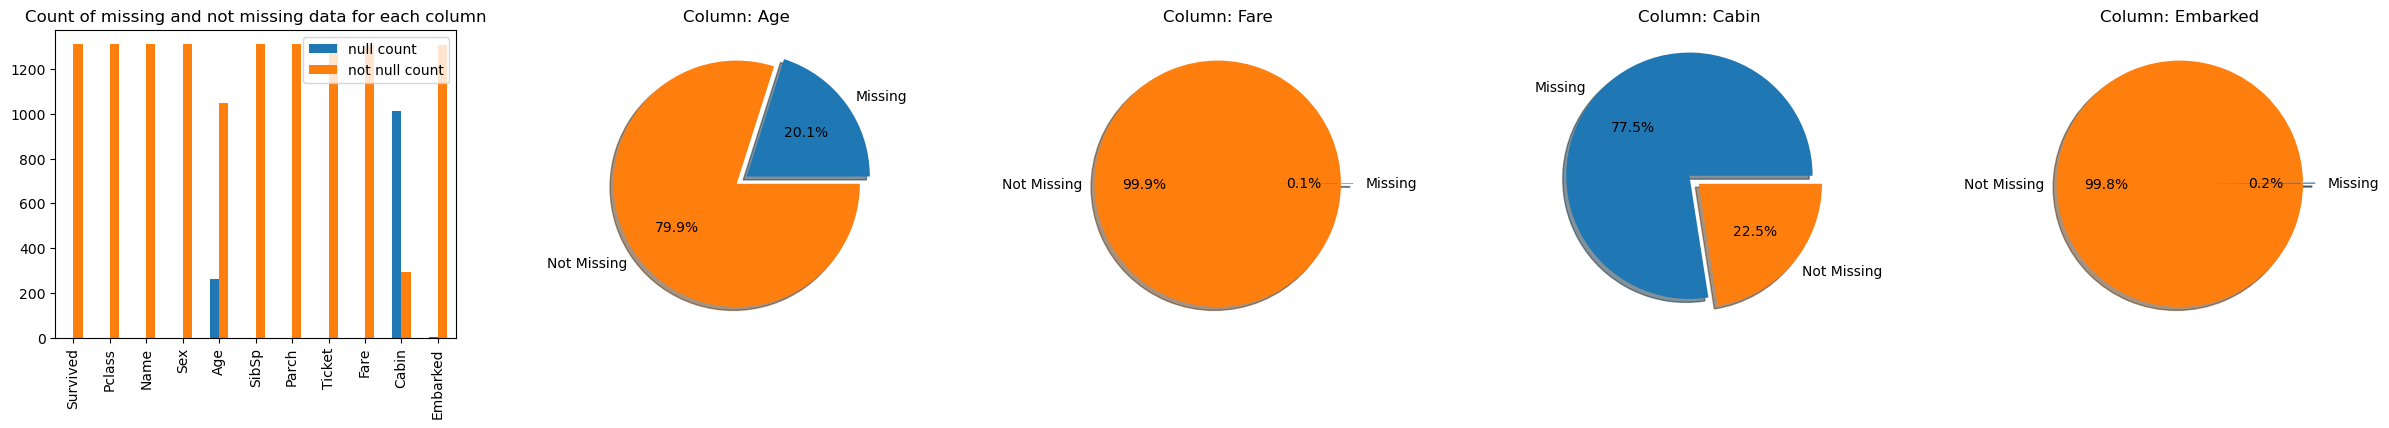

In [74]:
# Plotting
fig, axes = plt.subplots(1, len(null_columns) + 1, figsize=(30, 4))

# Bar plot
vis_df.plot(
            kind='bar',
            stacked=False,
            title='Count of missing and not missing data for each column',
            ax=axes[0]
                )

# Pie plots
for i in range(len(null_columns)):
    axes[i + 1].pie(null_columns[i][1:], labels = ['Missing', 'Not Missing'], autopct='%1.1f%%', shadow=True, explode=(0.1, 0) )
    axes[i + 1].set_title(f'Column: {null_columns[i][0]}')
    
plt.show()

I will drop columns `Name`, `Cabin` and `Ticket` because they are obviously not related to the survivel of the passenger.

In [75]:
df = df.drop(['Cabin', 'Ticket', 'Name'], axis=1)

For handling `Fare` null values, we can use the **mean** of `Age` based on `Pclass` and `Sex`.

In [76]:
grouped_series = df.groupby(['Pclass', 'Sex'])['Fare'].mean()
grouped_series

Pclass  Sex   
1       female    109.412385
        male       69.888385
2       female     23.234827
        male       19.904946
3       female     15.324250
        male       12.415462
Name: Fare, dtype: float64

In [77]:
sex, pclass = df.loc[df[df['Fare'].isnull()].index, ['Sex', 'Pclass']].values[0]
df.loc[df[df['Fare'].isnull()].index, 'Fare'] = np.floor(grouped_series[pclass, sex])

For handling `Embarked` column, we will use the `Pclass` and put the Embarked with the maximum number of entries as the `NaN` values./

In [78]:
df.groupby(['Pclass', 'Embarked'])['SibSp'].count()

Pclass  Embarked
1       C           141
        Q             3
        S           177
2       C            28
        Q             7
        S           242
3       C           101
        Q           113
        S           495
Name: SibSp, dtype: int64

In [79]:
df.loc[df[df['Embarked'].isnull()].index, 'Embarked'] = 'S'

Converting Categorical data to numerical data

In [80]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [81]:
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

In [87]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda c: c.cat.codes)

We use `IterativeImputer` method for filling age missing values.

In [88]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [89]:
X = df[['Pclass', 'Sex', 'Fare', 'Age']]

imputer = IterativeImputer()
imp_vals = imputer.fit_transform(X)
df[['Pclass', 'Sex', 'Fare', 'Age']] = imp_vals
df['Age'] = df['Age'].apply(lambda age: np.floor(age) if age > 1 else age)

In [90]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Converting data types as needed

In [91]:
train_df.select_dtypes(['category']).columns

Index([], dtype='object')

# Statistical Analysis and Visualization

## Passenger's population By Different Groups

In [92]:
gender_series = df.groupby('Sex')['Sex'].count()
gpops = gender_series.values

pclass_series = df.groupby('Pclass')['Pclass'].count()
ppops = pclass_series.values

embarked_series = df.groupby('Embarked')['Embarked'].count()
epops = embarked_series.values



In [93]:
embarked_series.index

Index([0, 1, 2], dtype='int8', name='Embarked')

In [94]:
epops

array([270, 123, 916], dtype=int64)

In [95]:
pclass_series

Pclass
1.0    323
2.0    277
3.0    709
Name: Pclass, dtype: int64

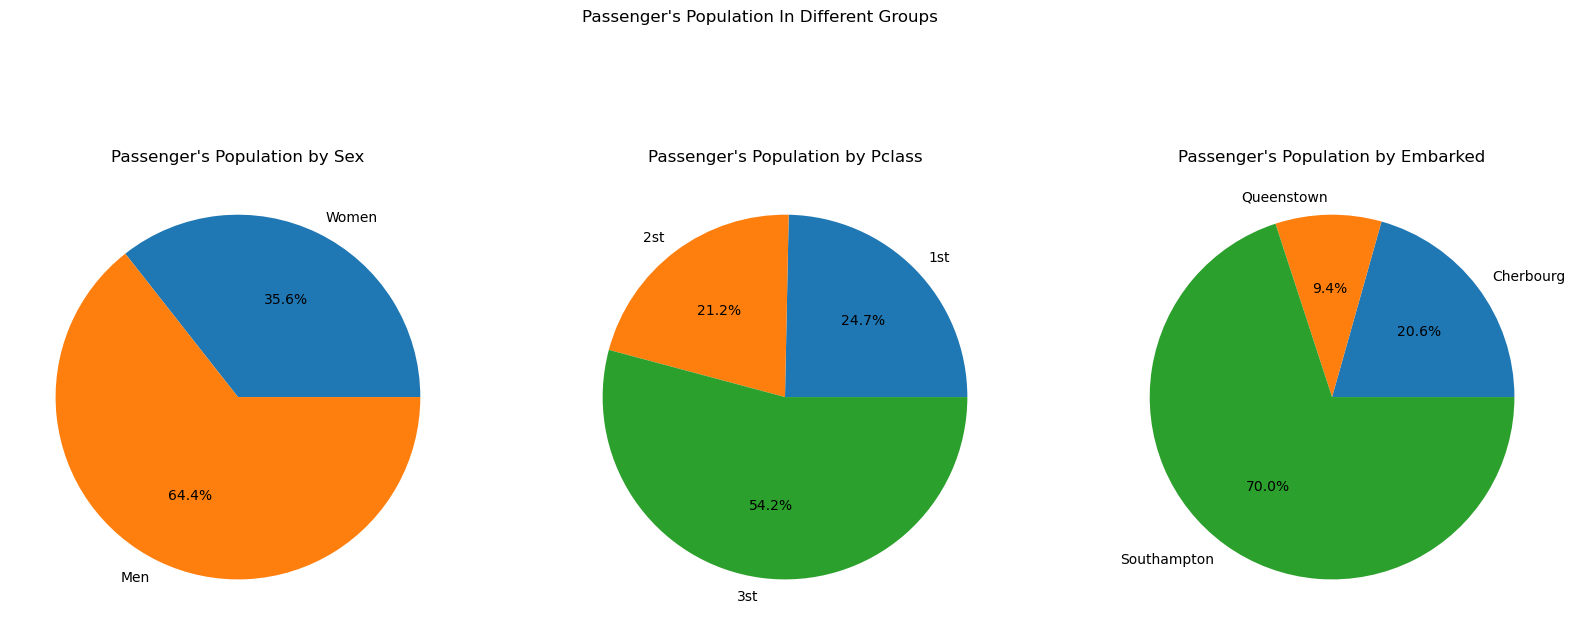

In [101]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].pie(gpops, labels=['Women', 'Men'], autopct='%1.1f%%')
axes[0].set_title('Passenger\'s Population by Sex')

axes[1].pie(ppops, labels=['1st', '2st', '3st'], autopct='%1.1f%%')
axes[1].set_title('Passenger\'s Population by Pclass')

axes[2].pie(epops, labels=['Cherbourg', 'Queenstown', 'Southampton'], autopct='%1.1f%%')
axes[2].set_title('Passenger\'s Population by Embarked')


fig.suptitle('Passenger\'s Population In Different Groups')
plt.show()

## Survival Rate Between Different Groups

In [50]:
sexSeries = df.groupby(by=['Survived', 'Sex'])['Sex'].count()
sexSeries

Survived  Sex
0         0.0     81
          1.0    734
1         0.0    385
          1.0    109
Name: Sex, dtype: int64

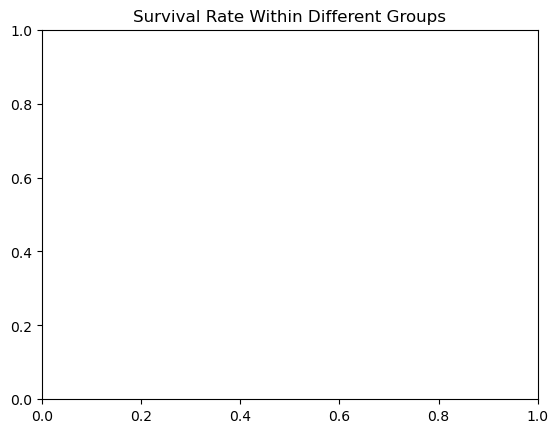

In [103]:
num_survived = df['Survived'].sum()
num_passengers = df['Survived'].count()




axes[0].pie([num_survived, num_passengers - num_survived], labels=['Survived', 'Died'], autopct='%1.1f%%')

# Rate of Survival
sexSeries = df.groupby(by=['Survived', 'Sex'])['Survived'].count()

# axes[1].pie([sexSeries['0', ]])

plt.title('Survival Rate Within Different Groups')
plt.show()


In [ ]:
# Plotting

fig, axes = plt.subplots(1, 4, figsize=(30, 4))